<a href="https://colab.research.google.com/github/AIGeekProgrammer/MiscellaneousAI/blob/main/NLP/MLP_for_character_level_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook: MLP for character-level predictions<br>
Author: Szymon Manduk<br>
Date: Nov 7, 2022<br>
Description: implementing multilayer perceptron for character-level prediction  - based on the idea presented by A. Karpathy: https://youtu.be/TCH_1BHY58I and the original paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf<br>

In [ ]:
import torch
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# We open the file with names (names.txt), read names into a list while removing newline 
# and adding character '.' the end of each word.
words = []
with open('/gdrive/My Drive/Test/names.txt', 'r') as f:
  for cnt, line in enumerate(f.readlines()):
    words.append(line.rstrip('\n') + '.')
print(words[:5])
print(f'Number of words {len(words)}')

['emma.', 'olivia.', 'ava.', 'isabella.', 'sophia.']
Number of words 32033


In [ ]:
# We build a list of all unique letters ...
s = set()
for word in words:
  s.update(list(word))
letters = sorted(list(s))
letters[:15]

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']

In [ ]:
# ... to be able to convert from a letter to a number and vice versa.
char2idx = {ch:i for i,ch in enumerate(letters)}
idx2char = {i:ch for i,ch in enumerate(letters)}
print(f'Ex: Index for f is {char2idx["f"]}')
print(f'Ex: Character for index 14 is {idx2char[14]}')
print(f'Ex: Character for index 0 is {idx2char[0]}')

Ex: Index for f is 6
Ex: Character for index 14 is n
Ex: Character for index 0 is .


In [ ]:
# Now, we're ready to build the data and label datasets. We need them in a form of:
# - data: list of length, containing subsequent letters from a word
# - label: list containing the letter that comes after n letters in data.
# Let's start with the first few words only to check if it works properly.

x, y = [], []  # data and labels lists

for _ in range(5):  # let's randomly check 5 words
  length = torch.randint(3, 7, (1,)).item()  # just for testing: randomly choose how many characters do we want to use predicting the next character
  word = words[torch.randint(0, len(words), (1,)).item()]  # randomly choose word index
  
  data = '.' * length  # fill data with dots
  for ch in word:
    y.append(ch) # append label
    x.append(data)  # append data
    data = data[1:] + ch  # alter data so that it contains one (more) character from the word
      
  # Debugging results
  print(f'Word: {word}')
  print(f'Length of n-gram: {length}')
  print(f'Data: {x}')
  print(f'Labels: {y}\n')
  x, y = [], []

Word: anne.
Length of n-gram: 5
Data: ['.....', '....a', '...an', '..ann', '.anne']
Labels: ['a', 'n', 'n', 'e', '.']

Word: hendrik.
Length of n-gram: 6
Data: ['......', '.....h', '....he', '...hen', '..hend', '.hendr', 'hendri', 'endrik']
Labels: ['h', 'e', 'n', 'd', 'r', 'i', 'k', '.']

Word: vinny.
Length of n-gram: 5
Data: ['.....', '....v', '...vi', '..vin', '.vinn', 'vinny']
Labels: ['v', 'i', 'n', 'n', 'y', '.']

Word: mikah.
Length of n-gram: 5
Data: ['.....', '....m', '...mi', '..mik', '.mika', 'mikah']
Labels: ['m', 'i', 'k', 'a', 'h', '.']

Word: spencer.
Length of n-gram: 4
Data: ['....', '...s', '..sp', '.spe', 'spen', 'penc', 'ence', 'ncer']
Labels: ['s', 'p', 'e', 'n', 'c', 'e', 'r', '.']



In [ ]:
# Now we can create data and label lists for the whole dataset, assuming the length is 3 characters.

# Let's measure time elapsed - just for practise.
from timeit import default_timer as timer
start = timer()

x, y = [], []  # data and labels lists
length = 3

for word in words:  
  data = '.' * length  # fill data with dots
  for ch in word:
    y.append(ch) # append label
    x.append(data)  # append data
    data = data[1:] + ch  # alter data so that it contains one (more) character from the word

end = timer()
print(f'Dataset contains {len(y)} elements, computed within {end-start:.2f} seconds.')

Dataset contains 228146 elements, computed within 0.24 seconds.


In [ ]:
# Let's look at an example batch.
print(x[10220:10227])
print(y[10220:10227])

['lyn', '...', '..a', '.ad', 'adi', 'dil', 'ily']
['.', 'a', 'd', 'i', 'l', 'y', 'n']


In [ ]:
# We convert characters in data and labels into numbers and from lists to tensors
data = torch.empty((len(y), length), dtype=torch.int64)
labels = torch.empty((len(y), ), dtype=torch.int64)
print(data.shape)
print(labels.shape)

for i, trigram in enumerate(x):
  for j, ch in enumerate(trigram):
    data[i,j] = char2idx[ch]
for i, label in enumerate(y):
  labels[i] = char2idx[label]
# print(data[10220:10227])
# print(labels[10220:10227])

torch.Size([228146, 3])
torch.Size([228146])


In [ ]:
data

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [ ]:
labels

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [ ]:
# As the idea of this notebook is based on this work: Bengio et al. 2003 MLP language model paper (pdf): https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf,
# we need to create an embedding table in which we will embedd each character from our data tensor into N-dimentional embedding.
# Here we use 2-dimentional embeddings for each of our letters.
emb_dim = 2
emb = torch.randn(len(letters), emb_dim, requires_grad=True)
for i, e in enumerate(emb):
  print(f'{i} : {e}')

0 : tensor([0.2693, 1.7548], grad_fn=<UnbindBackward0>)
1 : tensor([-1.2506, -1.6556], grad_fn=<UnbindBackward0>)
2 : tensor([1.2044, 0.9200], grad_fn=<UnbindBackward0>)
3 : tensor([-0.4333, -0.2287], grad_fn=<UnbindBackward0>)
4 : tensor([-0.0069, -0.4519], grad_fn=<UnbindBackward0>)
5 : tensor([-0.8248, -0.2599], grad_fn=<UnbindBackward0>)
6 : tensor([-0.3566, -0.5098], grad_fn=<UnbindBackward0>)
7 : tensor([ 1.1725, -0.1151], grad_fn=<UnbindBackward0>)
8 : tensor([-0.7304, -1.2691], grad_fn=<UnbindBackward0>)
9 : tensor([-0.3946, -0.1323], grad_fn=<UnbindBackward0>)
10 : tensor([-0.7607, -1.3150], grad_fn=<UnbindBackward0>)
11 : tensor([-1.0425, -0.3478], grad_fn=<UnbindBackward0>)
12 : tensor([-1.3718, -0.7268], grad_fn=<UnbindBackward0>)
13 : tensor([0.1731, 0.5872], grad_fn=<UnbindBackward0>)
14 : tensor([0.8870, 0.1290], grad_fn=<UnbindBackward0>)
15 : tensor([0.0258, 0.1462], grad_fn=<UnbindBackward0>)
16 : tensor([-0.6157,  0.8806], grad_fn=<UnbindBackward0>)
17 : tensor([-0.0

In [ ]:
# We can pick any arbitrary data in our training dataset (here: datapoints at positions from 10220 to 10227,
# which constitues a 3-grams: 'lyn', '...', '..a', '.ad', 'adi', 'dil', 'ily') ...
example = [10220, 10221, 10222, 10223, 10224, 10225, 10226, 10227]
print(f'Data:\n {data[example]}\n')
# ... and we can get the corresponding embeddings.
print(f'Correspoding embeddings:\n {emb[data[example]]} \n with the shape of: {emb[data[example]].shape}')

Data:
 tensor([[12, 25, 14],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1,  4],
        [ 1,  4,  9],
        [ 4,  9, 12],
        [ 9, 12, 25],
        [12, 25, 14]])

Correspoding embeddings:
 tensor([[[-1.3718, -0.7268],
         [ 1.1030,  0.8068],
         [ 0.8870,  0.1290]],

        [[ 0.2693,  1.7548],
         [ 0.2693,  1.7548],
         [ 0.2693,  1.7548]],

        [[ 0.2693,  1.7548],
         [ 0.2693,  1.7548],
         [-1.2506, -1.6556]],

        [[ 0.2693,  1.7548],
         [-1.2506, -1.6556],
         [-0.0069, -0.4519]],

        [[-1.2506, -1.6556],
         [-0.0069, -0.4519],
         [-0.3946, -0.1323]],

        [[-0.0069, -0.4519],
         [-0.3946, -0.1323],
         [-1.3718, -0.7268]],

        [[-0.3946, -0.1323],
         [-1.3718, -0.7268],
         [ 1.1030,  0.8068]],

        [[-1.3718, -0.7268],
         [ 1.1030,  0.8068],
         [ 0.8870,  0.1290]]], grad_fn=<IndexBackward0>) 
 with the shape of: torch.Size([8, 3, 2])


In [ ]:
# Now, we move into constructing a neural network that takes 3 characters (converted into ints and then converted into embeddings like above).
# Those embeddings are then transformed into a hidden layer of size h_size, then activated by tanh activation function.
# Then a signal goes to the output layer with 27 neurons (corresponding to 27 letters).
# The output is softmaxed to get probability distribution of the next character. 
# A loss can be calculated with CrossEntropy function and the whole model 
# might be backpropagated up to embeddings, so that they will be fitted to the training dataset.

h_size = 100  # the size of the hidden layer

# 3 characters embeded in the 2-dim space of embeddings gives us 6 inputs mapped on to h_size neurons in the hidden layer
W1 = torch.randn((length*emb_dim, h_size), requires_grad=True)  
b1 = torch.randn(h_size, requires_grad=True)  # bias
print(f'W1 shape: {W1.shape}, type: {W1.dtype}. Bias shape: {b1.shape}')

W1 shape: torch.Size([6, 100]), type: torch.float32. Bias shape: torch.Size([100])


In [ ]:
# We want be able to feed our model with vectors of size embeding dimention 
# (here emb_dim=2) times n-gram length (here length=3) that equals 6 elements.
# Let's take a look at the shape.
emb[data[[example[3]]]].view(-1, length*emb_dim).shape

torch.Size([1, 6])

In [ ]:
# And at some data as well.
emb[data[[example[3]]]].view(-1, length*emb_dim)

tensor([[ 0.2693,  1.7548, -1.2506, -1.6556, -0.0069, -0.4519]],
       grad_fn=<ViewBackward0>)

In [ ]:
# Every 3-gram embedded into 2 dimentions - so the size is 1x6 - will be in our model 
# multiplied by weigths matix of 6x100 and a bias will be added to each element.
emb[data[[example[3]]]].view(-1, length*emb_dim) @ W1 + b1

tensor([[ 1.4881,  3.8473, -0.0119,  9.2306,  3.9041, -0.1487,  1.6263, -3.8299,
          3.6102,  0.1941,  3.5407,  2.7260,  2.1970,  1.3020,  0.6092,  0.7827,
         -0.5906,  0.6666,  0.4678, -2.3617,  4.8591, -0.0197, -7.4429, -2.6018,
          0.7172,  3.2309, -0.7379,  2.4612,  1.7530,  2.0906,  1.3643, -3.6151,
         -0.7175, -0.1929, -1.1716,  0.4135, -0.7684,  2.3626,  2.8788,  3.5981,
          2.1995, -2.5262,  0.3396, -2.4847, -3.5211, -2.4184, -1.9381,  7.0572,
          2.5646, -2.8520, -1.7390,  1.3424,  2.5286,  0.3043,  0.5418,  0.0266,
         -0.2760, -1.8059, -1.3788,  3.5581, -1.9506,  1.3210, -1.1592, -1.9944,
         -0.9448, -2.4289,  3.1992,  3.2059, -5.5499,  0.5655,  1.2340,  1.0847,
          0.3649,  4.8948,  1.9556, -5.8657,  2.1201, -0.9133,  0.5383, -0.9931,
         -0.9490, -0.3868, -4.9691,  0.8360,  0.0500,  6.6749, -0.2155,  0.1442,
          2.2331,  0.8402,  2.3271, -1.8695,  0.1813, -4.0767, -0.7146, -7.2722,
         -4.0564,  2.8022,  

In [ ]:
# The output layer will be transforming a signal from hideen size of h_size=100 
# into size of 27 possible letters len(letters).
W2 = torch.randn((h_size, len(letters)), requires_grad=True)
b2 = torch.randn(len(letters), requires_grad=True)
print(W2.shape)
print(b2.shape)

torch.Size([100, 27])
torch.Size([27])


In [ ]:
# Before we do a forward pass and then backpropagate, we need to collect all 
# learnable parameters, so that we can zero-grad and update them later on.
parameters = [emb, W1, b1, W2, b2]  
# Counting the number of model's parameters.
print(f'The model has altogether {sum(param.nelement() for param in parameters)} learnable parameters')

The model has altogether 3481 learnable parameters


In [ ]:
# OK, let's try to do a single forward-backwards pass.

# First, we pick a random number for index of data that we are going to use in this pass.
idx = torch.randint(0, len(data), (1,)).item()

# We get data and label for the randomly chosen index (x and y).
x = emb[data[idx]].view(-1, length*emb_dim)
y = labels[idx].unsqueeze(0)  # to get 1-dim tensor that will be expected by cross_entropy instead of 0-dmin
print(f'Index: {idx}. Label: {y.item()}. Data shape: {x.shape}. Label shape: {y.shape}')

# We do a forward pass.
hidden = torch.tanh(x @ W1 + b1)
logits = hidden @ W2 + b2
pred = torch.softmax(logits, dim=1)
print(f'Logits:\n{logits}')
print(f'Prediction: {torch.argmax(pred).item()}. Should be {y.item()}')

# The we use the CrossEntropy function to calculate a loss.
from torch.nn.functional import cross_entropy
loss = cross_entropy(logits, y)
print(f'Loss: {loss.item()}')

Index: 184696. Label: 9. Data shape: torch.Size([1, 6]). Label shape: torch.Size([1])
Logits:
tensor([[  6.8977,   4.5065,   9.8441,  -5.2872,  12.1559,   3.6251,  -0.5758,
          -0.8921,  11.1050,  -3.4304,  -8.1241, -12.6601,   8.7615,   0.9100,
          -2.2228,  -8.3410, -20.7316, -11.0152,  12.0085, -19.4439,   2.2679,
           0.9950,  11.8976,  -9.6503, -10.7528,  -7.7249, -12.6596]],
       grad_fn=<AddBackward0>)
Prediction: 4. Should be 9
Loss: 16.72532081604004


In [ ]:
# And now it's time for the backward pass.

# First, we zero gradients.
for param in parameters:
  param.grad = None

# Then we go backwards.
loss.backward()  

In [ ]:
# Let's see the gradients for our b1 biases.
for param in parameters[2:3]: 
  print(param.grad)

tensor([ 2.7315e-04,  3.2323e-01, -1.0227e-01, -1.5861e-03, -4.3172e-04,
        -2.7308e-04, -8.2726e-03, -6.7851e-01,  4.1354e-02,  3.6165e-06,
        -5.1492e-04,  1.4869e-04, -1.4341e-02,  1.0049e-01, -2.0725e-05,
         5.4841e-01, -3.4981e-03,  1.5697e-01, -1.8576e-01,  4.2770e-02,
        -2.0159e-04, -9.8106e-03, -1.1091e-01, -6.2708e-01, -4.5198e-02,
        -1.1895e+00,  2.1187e-01,  5.8905e-01,  1.5224e-03,  4.8668e-02,
        -2.4546e-03, -1.5316e-03,  2.9047e-04,  3.1712e-04,  4.4874e-02,
        -9.3830e-03,  2.3832e-01, -2.5587e-02,  4.5306e-03,  4.5509e-02,
         2.4533e-04, -4.2589e-02, -4.3642e-01, -4.0877e-01, -6.8858e-03,
        -5.3409e-03,  3.2786e-02, -1.7206e-02,  1.6420e-04,  8.4218e-03,
        -4.9038e-01, -2.1529e-03, -6.2331e-02, -1.3257e-02,  3.1162e-02,
        -2.7716e-01, -1.2623e-02, -2.0678e+00,  2.3530e-03,  7.6653e-04,
         1.8086e-01,  5.4529e-01, -2.1853e-01, -2.0314e+00,  5.3021e-03,
        -9.3283e-03,  7.1348e-04,  3.1051e-05, -8.8

In [ ]:
# Finally, we do parameters update using some learning rate.
learning_rate = 0.3
for param in parameters:
  param.data += -learning_rate * param.grad

In [ ]:
# And that's it - we did it!
# What we may do right now, as a next step, is to enclose the above passes in a loop.
# And also to train on a batch of data instead of a single datapoint.
batch_size = 1000
epochs = 50000
learning_rate = 1

In [ ]:
for epoch in range(1, epochs+1):
  # Let's randomly choose a batch of random indexes from the training dataset. 
  # We need batch_size of indexes.
  idx = torch.randint(0, len(data), (batch_size,))
  
  # We get the data and labels for the randomly chosen batch of indexes.
  x = emb[data[idx]].view(-1, length*emb_dim)
  y = labels[idx]

  # We do a forward pass.
  hidden = torch.tanh(x @ W1 + b1)
  logits = hidden @ W2 + b2
  loss = cross_entropy(logits, y)
 
  # Some debugging.
  if epoch % (epochs // 10) == 0:
    print(f'Loss at epoch #{epoch}: {loss.item()}')

  # We do a backward pass.
  for param in parameters:
    param.grad = None
  loss.backward()
  
  # We do parameters update.
  for param in parameters:
    param.data += -learning_rate * param.grad

  # To impove training, we add some learning rate decay.
  # After 50% of epochs we divide learning rate by 10. 
  if epoch == epochs // 2:
    learning_rate *= 0.1
    print(f'\n Changing learing rate to: {learning_rate}\n')
  # And we cut it further by half after 90% of epochs passed.
  if epoch == (epochs // 10) * 9:
    learning_rate *= 0.5
    print(f'\n Changing learing rate to: {learning_rate}\n')

Loss at epoch #5000: 2.3173444271087646
Loss at epoch #10000: 2.368964433670044
Loss at epoch #15000: 2.3065497875213623
Loss at epoch #20000: 2.2650322914123535
Loss at epoch #25000: 2.243694305419922

 Changing learing rate to: 0.1

Loss at epoch #30000: 2.2050209045410156
Loss at epoch #35000: 2.19743013381958
Loss at epoch #40000: 2.1508591175079346
Loss at epoch #45000: 2.248635768890381

 Changing learing rate to: 0.05

Loss at epoch #50000: 2.2356796264648438


In [ ]:
# We should be able to get a desent loss at around 2.27 (with around 50 000 epochs)
# Let's try to impove our model by:
# a) increasing the size of embeddings from 2 to 4,
# b) and creating a deeper net that will add some more flexibility to our model.
# We will also split data into train, validation and test datasets and all of that in some more Pytorch way of doing the stuff.

In [ ]:
# We still have our data and labels in variables 'data' and 'labels'. Let's double check this
print(f'Data size: {data.shape}')
print(f'Labels size: {labels.shape}')

Data size: torch.Size([228146, 3])
Labels size: torch.Size([228146])


In [ ]:
# Pytorch has a nice class TensorDataset to convert pair of data-labels 
# into the Dataset object that we may later on use with DataLoader
from torch.utils.data import TensorDataset, Dataset, DataLoader

dataset = TensorDataset(data, labels)
print(f'Type of the <dataset> variable is {type(dataset)}')
print(f'The length of the dataset is: {len(dataset)}')

Type of the <dataset> variable is <class 'torch.utils.data.dataset.TensorDataset'>
The length of the dataset is: 228146


In [ ]:
# Let's split data into training (80%), validation (10%) and test(10%) datasets.
# Pytorch has useful helper function to achieve this - random_split.
# Unfortunately, at the time of writing this notebook, Google Colab uses torch 1.12
# and in 1.12 random_split does not accept splits as percentage of original dataset.
torch.__version__

'1.12.1+cu113'

In [ ]:
# We may however copy-paste the code from 1.13 from here: https://pytorch.org/docs/1.12/_modules/torch/utils/data/dataset.html#random_split.
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])
print(f'The lengths of train, validation and test datasets are respectively: {len(train_dataset)}, {len(val_dataset)} and {len(test_dataset)}')

The lengths of train, validation and test datasets are respectively: 182517, 22815 and 22814


In [ ]:
# Let's redefine batch size
batch_size = 1024

In [ ]:
# Having datasets ready we may wrap them using DataLoader class.
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
# Let's try our data loader
for i, (x, y) in enumerate(train_dl):
  print(x.shape, y.shape)
  print(x)
  print(y)
  if i == 2:
    break

torch.Size([1024, 3]) torch.Size([1024])
tensor([[11,  5, 14],
        [ 0, 10,  9],
        [ 0,  0, 11],
        ...,
        [ 5, 12,  5],
        [25, 26,  1],
        [12,  9, 22]])
tensor([26,  1,  1,  ...,  1,  0,  5])
torch.Size([1024, 3]) torch.Size([1024])
tensor([[ 0,  0,  5],
        [ 1, 25, 12],
        [ 0,  1, 14],
        ...,
        [ 0,  0, 13],
        [ 0, 21, 12],
        [ 0, 25,  1]])
tensor([13,  5, 18,  ..., 25, 25, 14])
torch.Size([1024, 3]) torch.Size([1024])
tensor([[ 0, 22,  1],
        [ 9, 12, 25],
        [ 0,  0,  0],
        ...,
        [15,  6,  9],
        [10, 23,  1],
        [ 0,  0,  0]])
tensor([12, 14,  5,  ...,  1,  0, 12])


In [ ]:
# At this point we're ready to build a new model with increased 
# dimentionality of embeddings and with a deeper model.
import torch.nn as nn
from torch.nn import Linear, Tanh

class MLP(nn.Module):
  def __init__(self, letters_len, n_gram_len, emb_dim, h1_size, h2_size):
    super().__init__()
    self.n_gram_len = n_gram_len
    self.emb_dim = emb_dim
    self.emb = torch.randn(letters_len, emb_dim)  # dictionary size by embedding dimentionality
    self.fc1 = Linear(n_gram_len*emb_dim, h1_size)  # n-gram size times embedding dimentionality by size of hidden 1 
    self.fc2 = Linear(h1_size, h2_size)  # size of hidden 1 by size of hidden 2
    self.fc3 = Linear(h2_size, letters_len)
    self.Tanh = Tanh()
  
  def forward(self, x):
    # We need to embed and reshape our input tensor first. 
    # Quick note on why use .long() here. Theoretically model should work perfectly well with .emb[x].
    # The reason for this is that we have only integer values in the dataset.
    # However, if we want to use torchsummary to print model details, it will feed the model with float values.
    x = self.emb[x.long()].view(-1, self.n_gram_len*self.emb_dim)  
    hidden1 = self.Tanh(self.fc1(x))
    hidden2 = self.Tanh(self.fc2(hidden1))
    logits = self.fc3(hidden2)
    return logits

In [ ]:
dict_len = len(letters)  # dictionary size (should be 27)
n_gram_len = 3  # what's the size of n-gram (3 or more)
emb_dim = 4  # what's the dimentionality of embedding table (in previous ex. it was 2, we want increase that)
h1_size = 100  # hidden layer 1 size
h2_size = 50  # hidden layer 2 size
model = MLP(dict_len, n_gram_len, emb_dim, h1_size, h2_size)

In [ ]:
# We may print model structure with print method ...
print(model)

MLP(
  (fc1): Linear(in_features=12, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=27, bias=True)
  (Tanh): Tanh()
)


In [ ]:
# ... however I prefer using torch-summary where possible: https://github.com/sksq96/pytorch-summary
from torchsummary import summary
summary(model, (n_gram_len, emb_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]           1,300
              Tanh-2                  [-1, 100]               0
            Linear-3                   [-1, 50]           5,050
              Tanh-4                   [-1, 50]               0
            Linear-5                   [-1, 27]           1,377
Total params: 7,727
Trainable params: 7,727
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [ ]:
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR

# here we define some hyperparameters.
epochs = 600
learning_rate = 0.5  # this is initial learning rate - we are going to use scheduler to decrease LR
criterion = torch.nn.CrossEntropyLoss()  
optimizer = SGD(model.parameters(), lr=learning_rate)

# we use scheduler that multiplies LR by gamma every epoch given in milestones
scheduler = MultiStepLR(optimizer, milestones=[200,300,400,500], gamma=0.2)

# Note that the batch size is already defined in the DataLoaders.
print(f'The batch size is {batch_size}')

The batch size is 1024


In [ ]:
# Before we start the training, let's define a helper function that accepts
# data_loader and model and collects (in a form of list) accuracies 
# for each batch of a data loader. We may then use this function to calculate
# accuracy for validation and training datasets to check if there is any overfitting
def evaluate(data_loader, model):
  accuracy = []
  for x, y in data_loader:
    preds = model(x)  # logits
    predictions = torch.argmax(preds, dim=1).detach().cpu().numpy()  # predictions
    batch_accuracy = (predictions==y.detach().cpu().numpy()).sum() / len(y)  # compare predictions with ground truth and calculating accuracy for a batch
    accuracy.append(batch_accuracy)
  return accuracy

In [ ]:
# Main training loop
tr_losses = []
val_accuracies = []
tr_accuracies = []

start = timer()
for epoch in range(1, epochs+1):
  for x, y in train_dl:
    # forward pass
    y_hat = model(x)

    # backward pass
    loss = criterion(y_hat, y)
    loss.backward()

    # parameters update
    optimizer.step()
    optimizer.zero_grad()
  
  model.eval()
  with torch.no_grad():
    # train accuracy calculated every 10 epochs
    if epoch % 10 == 0:
      tr_accuracy = evaluate(train_dl, model) 
      tr_accuracies.append(np.array(tr_accuracy).sum() / len(tr_accuracy))

    # validation accuracy calculated in every epoch
    val_accuracy = evaluate(val_dl, model)
    val_accuracies.append(np.array(val_accuracy).sum() / len(val_accuracy))
  model.train()
  
  # learning rate decay
  scheduler.step()
  
  # record losses
  tr_losses.append(loss.detach().numpy().mean())

end = timer()
print(f'Learning time {end-start:0.2f}s. Last training loss: {tr_losses[-1]}')

Learning time 2989.88s. Last training loss: 2.1225686073303223


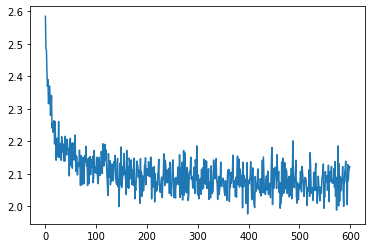

In [ ]:
# Print loss the validation accuracy, then training accuracy (this one collected every 10 epoch only)
import matplotlib.pyplot as plt
plt.plot(tr_losses)

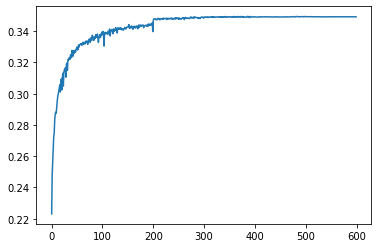

In [ ]:
plt.plot(val_accuracies)

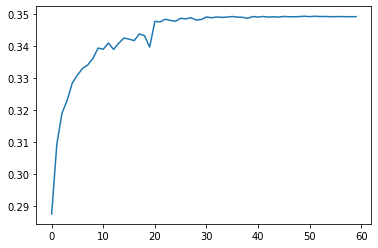

In [ ]:
plt.plot(tr_accuracies)

In [ ]:
# We're ready to use our trained model to generate names.
for _ in range(15): 
  prev_gram = torch.tensor([char2idx['.']]*3)  # we start with the initial n-gram of 3 starting characters
  pred_word = []  # this will be our predicted word
  while True:  # we run this loop until we get the ending '.' character
    # we get predicted logits
    output = model(prev_gram)  

    # we want to turn logits into probability distribution using softmax.
    prob_dist = torch.softmax(output, dim=1) 

    # and then draw from this distribution using multinomial probability distribution
    prediction = torch.multinomial(prob_dist, num_samples=1, replacement=True).squeeze(1)  # note: we need to squeeze as multinomial outputs extra dimention
    
    # calculate predicted character
    predicted_ch = idx2char[prediction.item()]  
    if predicted_ch == '.':  # if we get the ending character -> we have just predicted a whole word -> break while loop
      break
    
    pred_word.append(predicted_ch)  # add character to the word
    
    # we need to shift our 3-gram to the left and add newly predicted character to repeat loop
    prev_gram = torch.roll(prev_gram, -1)
    prev_gram[2] = prediction

  print(''.join(pred_word))

mailynoriann
eman
kumab
kammariyah
ewslett
aranfrean
alderret
kadalaya
joshir
yaballoheidy
cayziah
jon
jana
mona
tya
